In [1]:
import os
import imghdr
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from keras import layers
from keras.models import Sequential

2023-05-16 01:40:00.621644: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
data_dir = "/home/ec2-user/dataset/train"

In [3]:
img_exts = ["jpeg", "jpg", "png"]

In [4]:
for img_class in os.listdir(data_dir):
    for img in os.listdir(os.path.join(data_dir, img_class)):
        img_path = os.path.join(data_dir, img_class, img)
        try:
            cv.imread(img_path)
            _type = imghdr.what(img_path)
            if _type not in img_exts:
                print("img extension not in img_exts {}".format(img_path))
                os.remove(img_path)
        except Exception as e:
            print("issue with image {}".format(img_path))

In [5]:
# data = tf.keras.utils.image_dataset_from_directory(data_dir)

In [6]:
import pathlib

data_dir = pathlib.Path(data_dir)

In [7]:
image_count = len(list(data_dir.glob("*/*.jpg")))
print(image_count)

5640


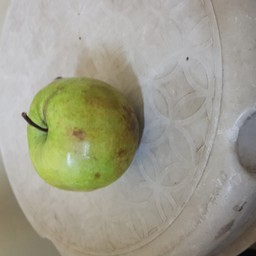

In [8]:
apples = list(data_dir.glob("apple/*"))
PIL.Image.open(str(apples[0]))

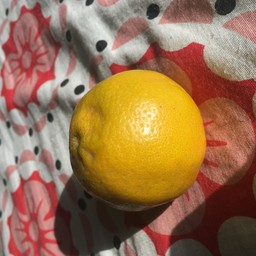

In [9]:
oranges = list(data_dir.glob("orange/*"))
PIL.Image.open(str(oranges[31]))

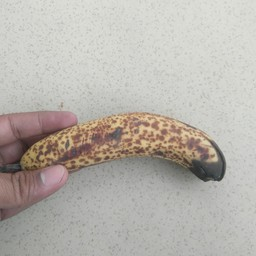

In [10]:
bananas = list(data_dir.glob("banana/*"))
PIL.Image.open(str(bananas[20]))

In [11]:
batch_size = 32
img_height = 180
img_width = 180

In [12]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

Found 5640 files belonging to 3 classes.
Using 4512 files for training.


2023-05-16 01:40:24.162165: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [13]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

Found 5640 files belonging to 3 classes.
Using 1128 files for validation.


In [14]:
class_names = train_ds.class_names
print(class_names)

['apple', 'banana', 'orange']


## Visualize the data


2023-05-16 01:40:44.797621: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [4512]
	 [[{{node Placeholder/_0}}]]
2023-05-16 01:40:44.798325: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [4512]
	 [[{{node Placeholder/_4}}]]


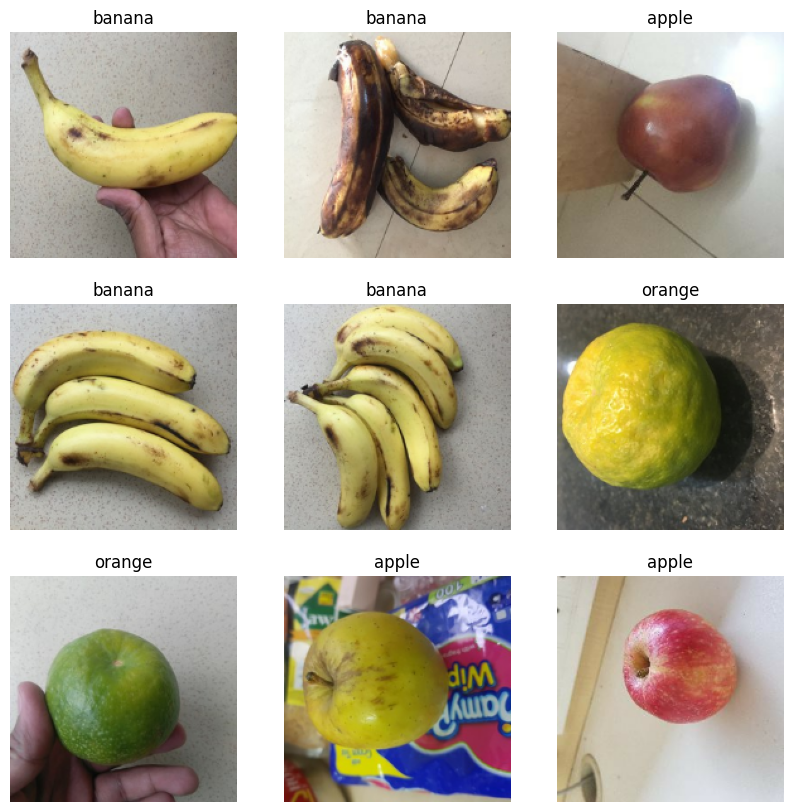

In [15]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## Configure the dataset for performance

In [16]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

In [17]:
# normalization_layer = layers.Rescaling(1.0 / 255)

In [18]:
# normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
# image_batch, labels_batch = next(iter(normalized_ds))
# first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
# print(np.min(first_image), np.max(first_image))

## Create the model



In [19]:
num_classes = len(class_names)

# model = Sequential(
#     [
#         layers.Rescaling(1.0 / 255, input_shape=(img_height, img_width, 3)),
#         layers.Conv2D(16, 3, padding="same", activation="relu"),
#         layers.MaxPooling2D(),
#         layers.Conv2D(32, 3, padding="same", activation="relu"),
#         layers.MaxPooling2D(),
#         layers.Conv2D(64, 3, padding="same", activation="relu"),
#         layers.MaxPooling2D(),
#         layers.Flatten(),
#         layers.Dense(128, activation="relu"),
#         layers.Dense(num_classes),
#     ]
# )

In [20]:
# model.compile(
#     optimizer="adam",
#     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#     metrics=["accuracy"],
# )

In [21]:
# model.summary()

In [22]:
# epochs = 10
# history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

In [23]:
# # print(history.history)
#
# acc = history.history["accuracy"]
# val_acc = history.history["val_accuracy"]
#
# loss = history.history["loss"]
# val_loss = history.history["val_loss"]
#
# epochs_range = range(epochs)
#
# plt.figure(figsize=(8, 8))
# plt.subplot(1, 2, 1)
# plt.plot(epochs_range, acc, label="Training Accuracy")
# plt.plot(epochs_range, val_acc, label="Validation Accuracy")
# plt.legend(loc="lower right")
# plt.title("Training and Validation Accuracy")
#
# plt.subplot(1, 2, 2)
# plt.plot(epochs_range, loss, label="Training Loss")
# plt.plot(epochs_range, val_loss, label="Validation Loss")
# plt.legend(loc="upper right")
# plt.title("Training and Validation Loss")
# plt.show()

## Resolving Overfit

### Data augmentation

In [24]:
# data_augmentation = keras.Sequential(
#     [
#         layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
#         layers.RandomRotation(0.1),
#         layers.RandomZoom(0.1),
#     ]
# )

In [25]:
# plt.figure(figsize=(10, 10))
# for images, _ in train_ds.take(1):
#     for i in range(9):
#         augmented_images = data_augmentation(images)
#         ax = plt.subplot(3, 3, i + 1)
#         plt.imshow(augmented_images[0].numpy().astype("uint8"))
#         plt.axis("off")

### Dropout

In [26]:
model = Sequential(
    [
        # data_augmentation,
        # layers.Rescaling(1.0 / 255),
        layers.Rescaling(1.0 / 255, input_shape=(img_height, img_width, 3)),
        layers.Conv2D(16, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),
        layers.Dropout(0.2),
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dense(num_classes, name="outputs"),
    ]
)

In [27]:
# model.compile(
#     optimizer="adam",
#     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#     metrics=["accuracy"],
# )

model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [29]:
epochs = 20
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/20


2023-05-16 01:40:59.141649: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [4512]
	 [[{{node Placeholder/_4}}]]
2023-05-16 01:40:59.142369: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [4512]
	 [[{{node Placeholder/_4}}]]


141/141 [==============================] - ETA: 0s - loss: 0.4788 - accuracy: 0.8019

2023-05-16 01:42:02.189850: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1128]
	 [[{{node Placeholder/_4}}]]
2023-05-16 01:42:02.195899: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1128]
	 [[{{node Placeholder/_4}}]]


141/141 [==============================] - 68s 443ms/step - loss: 0.4788 - accuracy: 0.8019 - val_loss: 0.1429 - val_accuracy: 0.9574
Epoch 2/20
141/141 [==============================] - 61s 432ms/step - loss: 0.1073 - accuracy: 0.9668 - val_loss: 0.1893 - val_accuracy: 0.9220
Epoch 3/20
141/141 [==============================] - 66s 468ms/step - loss: 0.0708 - accuracy: 0.9772 - val_loss: 0.0503 - val_accuracy: 0.9832
Epoch 4/20
141/141 [==============================] - 64s 458ms/step - loss: 0.0618 - accuracy: 0.9796 - val_loss: 0.0426 - val_accuracy: 0.9885
Epoch 5/20
141/141 [==============================] - 64s 449ms/step - loss: 0.0169 - accuracy: 0.9951 - val_loss: 0.0292 - val_accuracy: 0.9902
Epoch 6/20
141/141 [==============================] - 62s 438ms/step - loss: 0.0504 - accuracy: 0.9823 - val_loss: 0.0432 - val_accuracy: 0.9902
Epoch 7/20
141/141 [==============================] - 63s 446ms/step - loss: 0.0141 - accuracy: 0.9958 - val_loss: 0.5070 - val_accuracy: 0.8

## Visualize Training Results

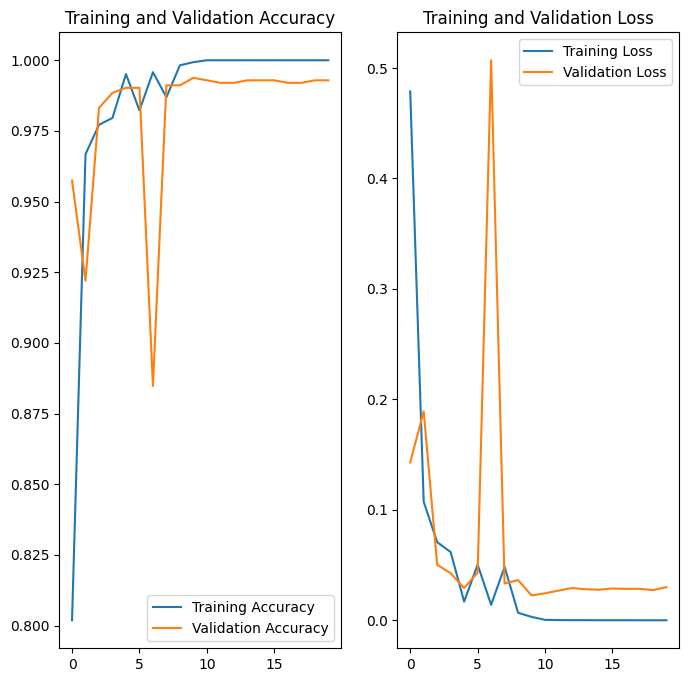

In [30]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show()

In [31]:
# from tensorflow.keras.metrics import Accuracy, Precision, Recall

# pre = Precision()
# re = Recall()
# acc = Accuracy()

# test = keras.utils.image_dataset_from_directory("rotten_fruits/train/test_/")

# for batch in test.as_numpy_iterator():
    # X, y = batch
    # yhat = model.predict(X)
    # pre.update_state(y, yhat)
    # re.update_state(y, yhat)
    # acc.update_state(y, yhat)

# print(f"Precision: {pre.result().numpy()}")
# print(f"Recall: {re.result().numpy()}")
# print(f"Accuracy: {acc.result().numpy()}")

### Test

In [37]:
def predict_image_from_path(img_path):
    img = tf.keras.utils.load_img(
        img_path, target_size=(img_height, img_width))

    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array, verbose=False)
    score = tf.nn.softmax(predictions[0])

    res = class_names[np.argmax(score)]
    percentage = 100 * np.max(score)
    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(res, percentage)
    )

    return res, percentage

In [ ]:
img_path = "/home/ec2-user/dataset/test/banana/"
predict_image_from_path(img_path)

#### One directory of images (change expected class)

In [38]:
test_dir = "/home/ec2-user/dataset/test/apple"

total_size = len(os.listdir(test_dir))
total_right = 0

expected_class = "apple"

for img in os.listdir(test_dir):
    img_path = os.path.join(test_dir, img)

    res, percentage = predict_image_from_path(img_path)

    if res == expected_class:
        total_right += 1

print(
    f"Result overall: got { total_right }/{ total_size } right, which means { round( total_right * 100 / total_size, 2) }%"
)

This image most likely belongs to apple with a 100.00 percent confidence.
This image most likely belongs to apple with a 100.00 percent confidence.
This image most likely belongs to apple with a 100.00 percent confidence.
This image most likely belongs to orange with a 72.12 percent confidence.
This image most likely belongs to apple with a 100.00 percent confidence.
This image most likely belongs to apple with a 100.00 percent confidence.
This image most likely belongs to apple with a 99.99 percent confidence.
This image most likely belongs to apple with a 100.00 percent confidence.
This image most likely belongs to apple with a 100.00 percent confidence.
This image most likely belongs to apple with a 100.00 percent confidence.
This image most likely belongs to apple with a 100.00 percent confidence.
This image most likely belongs to apple with a 100.00 percent confidence.
This image most likely belongs to apple with a 100.00 percent confidence.
This image most likely belongs to apple

This image most likely belongs to apple with a 99.99 percent confidence.
This image most likely belongs to apple with a 100.00 percent confidence.
This image most likely belongs to apple with a 99.99 percent confidence.
This image most likely belongs to apple with a 100.00 percent confidence.
This image most likely belongs to apple with a 100.00 percent confidence.
This image most likely belongs to apple with a 100.00 percent confidence.
This image most likely belongs to apple with a 100.00 percent confidence.
This image most likely belongs to apple with a 100.00 percent confidence.
Result overall: got 119/120 right, which means 99.17%


#### Directories with images of three classes

In [39]:
test_dir = "/home/ec2-user/dataset/test/"

apples_right = 0
oranges_right = 0
bananas_right = 0

for img_class in os.listdir(test_dir):
    for img in os.listdir(os.path.join(test_dir, img_class)):
        img_path = os.path.join(test_dir, img_class, img)

        res, percentage = predict_image_from_path(img_path)

        if img_class == "apple" and res == "apple":
            apples_right += 1
        elif img_class == "banana" and res == "banana":
            bananas_right += 1
        elif img_class == "orange" and res == "orange":
            oranges_right += 1
    print()

apples_size = len(os.listdir(os.path.join(test_dir, "apple")))
bananas_size = len(os.listdir(os.path.join(test_dir, "banana")))
oranges_size = len(os.listdir(os.path.join(test_dir, "orange")))
total_size = apples_size + bananas_size + oranges_size
total_right = apples_right + bananas_right + oranges_right

print(
    f"Result apples: got { apples_right }/{ apples_size } right, which means { round(apples_right * 100 / apples_size, 2) }%"
)
print(
    f"Result bananas: got { bananas_right }/{ bananas_size } right, which means { round(bananas_right * 100 / bananas_size, 2) }%"
)
print(
    f"Result oranges: got { oranges_right }/{ oranges_size } right, which means { round(oranges_right * 100 / oranges_size, 2) }%"
)
print()
print(
    f"Result overall: got { total_right }/{ total_size } right, which means { round( total_right * 100 / total_size, 2) }%"
)

This image most likely belongs to apple with a 100.00 percent confidence.
This image most likely belongs to apple with a 100.00 percent confidence.
This image most likely belongs to apple with a 100.00 percent confidence.
This image most likely belongs to orange with a 72.12 percent confidence.
This image most likely belongs to apple with a 100.00 percent confidence.
This image most likely belongs to apple with a 100.00 percent confidence.
This image most likely belongs to apple with a 99.99 percent confidence.
This image most likely belongs to apple with a 100.00 percent confidence.
This image most likely belongs to apple with a 100.00 percent confidence.
This image most likely belongs to apple with a 100.00 percent confidence.
This image most likely belongs to apple with a 100.00 percent confidence.
This image most likely belongs to apple with a 100.00 percent confidence.
This image most likely belongs to apple with a 100.00 percent confidence.
This image most likely belongs to apple

This image most likely belongs to apple with a 99.99 percent confidence.
This image most likely belongs to apple with a 100.00 percent confidence.
This image most likely belongs to apple with a 99.99 percent confidence.
This image most likely belongs to apple with a 100.00 percent confidence.
This image most likely belongs to apple with a 100.00 percent confidence.
This image most likely belongs to apple with a 100.00 percent confidence.
This image most likely belongs to apple with a 100.00 percent confidence.
This image most likely belongs to apple with a 100.00 percent confidence.

This image most likely belongs to banana with a 100.00 percent confidence.
This image most likely belongs to banana with a 99.99 percent confidence.
This image most likely belongs to banana with a 100.00 percent confidence.
This image most likely belongs to banana with a 100.00 percent confidence.
This image most likely belongs to banana with a 99.95 percent confidence.
This image most likely belongs to ba

This image most likely belongs to banana with a 100.00 percent confidence.
This image most likely belongs to banana with a 99.35 percent confidence.
This image most likely belongs to banana with a 100.00 percent confidence.
This image most likely belongs to banana with a 100.00 percent confidence.
This image most likely belongs to banana with a 100.00 percent confidence.
This image most likely belongs to banana with a 100.00 percent confidence.
This image most likely belongs to banana with a 100.00 percent confidence.
This image most likely belongs to banana with a 99.94 percent confidence.
This image most likely belongs to banana with a 100.00 percent confidence.
This image most likely belongs to banana with a 100.00 percent confidence.
This image most likely belongs to banana with a 100.00 percent confidence.
This image most likely belongs to banana with a 100.00 percent confidence.
This image most likely belongs to banana with a 100.00 percent confidence.
This image most likely belo

This image most likely belongs to orange with a 100.00 percent confidence.
This image most likely belongs to orange with a 100.00 percent confidence.
This image most likely belongs to orange with a 100.00 percent confidence.
This image most likely belongs to orange with a 100.00 percent confidence.
This image most likely belongs to orange with a 100.00 percent confidence.
This image most likely belongs to orange with a 100.00 percent confidence.
This image most likely belongs to orange with a 100.00 percent confidence.
This image most likely belongs to orange with a 100.00 percent confidence.
This image most likely belongs to orange with a 100.00 percent confidence.
This image most likely belongs to orange with a 100.00 percent confidence.
This image most likely belongs to orange with a 100.00 percent confidence.
This image most likely belongs to orange with a 100.00 percent confidence.
This image most likely belongs to orange with a 99.99 percent confidence.
This image most likely bel

## Save Model


In [40]:
model.save('models/fruitclassifier.h5')

In [42]:
import boto3

s3 = boto3.resource('s3')
BUCKET = "fruit-lens-dream-team-user-data"
new_model = tf.keras.models.load_model('models/fruitclassifier.h5')
s3.Bucket(BUCKET).upload_file(new_model)

new_model.summary()

TypeError: bucket_upload_file() missing 1 required positional argument: 'Key'

In [ ]:
# from tensorflow.keras.metrics import Accuracy, Precision, Recall, SparseCategoricalAccuracy
from tensorflow.keras.metrics import SparseCategoricalAccuracy

# pre = Precision()
# re = Recall()
acc = SparseCategoricalAccuracy()

test = keras.utils.image_dataset_from_directory("data/rotten_fruits/test/test_/", image_size=(img_height, img_width))

for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    # pre.update_state(y, yhat)
    # re.update_state(y, yhat)
    acc.update_state(y, yhat)

# print(f"Precision: {pre.result().numpy()}")
# print(f"Recall: {re.result().numpy()}")
print(f"Accuracy: {acc.result().numpy()}")

### Testing with apple photos taken by me

In [ ]:
# new_model = tf.keras.models.load_model('models/fruitclassifier.h5')
# new_model.summary()

test_dir = "data/macas_real"

total_size = len(os.listdir(test_dir))
total_right = 0

expected_class = "apple"

for img in os.listdir(test_dir):
    img_path = os.path.join(test_dir, img)

    img = tf.keras.utils.load_img(
        img_path, target_size=(img_height, img_width))

    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array, verbose=False)
    score = tf.nn.softmax(predictions[0])

    res = class_names[np.argmax(score)]
    percentage = 100 * np.max(score)
    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(res, percentage)
    )

    if res == expected_class:
        total_right += 1

print(
    f"Result overall: got { total_right }/{ total_size } right, which means { round( total_right * 100 / total_size, 2) }%"
)
